In [ ]:
import matplotlib.pyplot as plt
from networkx import nx
from networkx.readwrite import json_graph
import json
import math
import random as rn
import numpy as np
import datetime as datetime
from numpy.random import choice as np_choice

# Создаем и сохраняем граф
Создаем и записываем граф в файл, это необходимо, чтобы тестировать и обучать популяции по Ламарку и по Дарвину можно было в одинаковых условиях (на одинаковых графах).

Также было принято решение отказаться от направленного графа для упрощения задачи. Сложность вызвало создание направленного графа в котором гарантировано будет хотя бы один маршрут из точки А в точку Б.*Курсив*

In [ ]:
def generate_graph(_iteration_number):
  n = 1024  # TODO: 1024 nodes
  m = 1200  # от N до 3xN ???
  general_graph = nx.gnm_random_graph(n, m, directed=False)
  export_graph = json_graph.node_link_data(general_graph)
  with open('/content/sample_data/darvin_graph_'+iteration_number+'.json', 'w') as writefile:
    writefile.write(json.dumps(export_graph))

In [ ]:
iteration_number = '17'
generate_graph(iteration_number)

In [ ]:
# Считываем граф из файла
file_name = "darvin_graph_"+iteration_number+".json"
g = nx.DiGraph()
with open('/content/sample_data/'+file_name, 'r') as readfile:
  js_graph = json.load(readfile)
  g = json_graph.node_link_graph(js_graph, directed=True)

# итерация узлов
if len(g.nodes)<50 :
  for i in range(0, len(g.nodes)):
    print(i)
    print(g.edges(i))


# Рисуем граф если граф тестовый (граф из 1024 точек адекватно не отображается)
if len(g.nodes)<50 :
  nx.draw(g, with_labels=True)
  plt.show()

print("Граф готов")

Граф готов


# Новый раздел

# Генетический алгоритм, с популяцией по Дарвину
Cчитаем что точка А - это G[0], точка B - это G[nodes-1].  

0) Стартовая популция - число частиц в точке A. Задается, как гиперпараметр n_start. Частица имеет следюущую структуру:


> coord - координаты местонахожления (вершина графа)  
  w - вес частицы (стартовое значение 1)  
  r - расстояние (длина кратчайшего пути от coord до точки B)


1) Кажда частица совершает случайные блуждания по маршруту n_iterations эпох, пока не достигнет цели(точки B) или не "умрет":  
> 1.1) Совершаем max_item_iterations случайных переходов частицей или пока частица не достигнем цели.  
  1.2) Если частица достигла цели, инкрементируем число достигших цели точек и "убиваем" частицу. Если частица не достигла цели, пересчитываем её вес.  
  1.3) Вес рассчитывается, как:  
  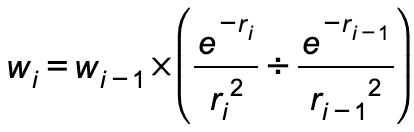  
   где i - текущая эпоха,    
   r - расстояние от текущей точки до B  
   e - константа ~2.72  
  1.4) Если новый w(вес частицы) < 1, с вероятностью 1-w "убиваем" частицу.   
  1.5) Если новый w(вес частицы) >= 2, расщепляем частицу на floor(w), с весами w/floor(w).

2) Завершаем алгоритм, если все выжившие частицы достигли цели или если все частицы погибли или пройден лимит эпох.  
3) Выводим число пройденных эпох, число частиц достигших цели, время выполнения алгоритма.


In [ ]:
class DarvinColony(object):

  def __init__(self, graph, n_start, n_iterations, max_item_iterations, debug = False):
    self.graph = graph # Итерируемый граф
    self.distances  = nx.to_numpy_array(graph) # Матрица переходов
    self.n_start = n_start # Размер начальной популяции
    self.n_iterations = n_iterations # Число итераций блуждания
    self.max_item_iterations = max_item_iterations # Максимальное число переходов за итерацию блуждания
    self.debug = debug # Выводить логи?

    self.quantums = [] # Массив частиц
    self.targetIterations = 0 # Число затраченых итераций
    self.targetQuantums = 0 # Число частиц достигших цели
    self.summWeight = 0
    self.allQ = n_start
    self.time_start = 0 # Время старта итераций
    self.time_end = 0 # Время завершения итераций

  def getMetrics(self):
    return {
        'ratio': self.targetQuantums/self.n_start,
        'targetPerSecond': self.targetQuantums/(self.time_end-self.time_start).total_seconds()
    }
  def getDispMetrics(self):
    return {
        'weight': self.summWeight/self.n_start,
        'time': (self.time_end-self.time_start).total_seconds(),
    }

  # Запускаем итерации частиц (соответствует Шагу 1)
  def run(self):
    self.time_start = datetime.datetime.now()
    best_way = len(nx.dijkstra_path(self.graph, 0, len(g.nodes)-1)) # Кратчайший путь от A до B
    self.genQuantums(best_way)

    self.targetIterations = self.n_iterations
    for i in range(0, self.n_iterations):
      #print("---- Итерация #{} ----".format(i))
      self.gen_all_paths() #  Каждая частица совершает случайные блуждания (Шаги 1.1-1.2)
      self.recalcWeight() # Пересчет весов (Шаг 1.3)
      self.kill() # Убийство частиц с учетом весов (Шаг 1.4)
      self.reproduction() # Размножение чатиц с учетом весов (Шаг 1.5)
      if len(self.quantums) == 0:
        self.targetIterations = i
        break
    self.time_end = datetime.datetime.now()
    
    if self.debug:
      print("---- Стартовые гиперпараметры ----")
      print("Кратчайший путь от A до B = {}".format(best_way))
      print("Начальный размер популяции {}, лимит итераций {}, лимит блужданий {}".format(self.n_start, self.n_iterations, self.max_item_iterations))
      print("---- Результаты ----")
      print("Число частиц достигших цели {}, за {} итераций, за время {} сек".format(self.targetQuantums,  self.targetIterations, self.time_end - self.time_start))
      print("Сумма весов {}".format(self.summWeight/self.n_start))
      print("Всего было создано частиц {}".format(self.allQ))

  # Инициализируем частицы
  def genQuantums(self, best_way):
    for i in range(0, self.n_start):
      self.quantums.append({'coord': 0, 'w': 1, 'r': best_way})

  def recalcWeight(self):
    for i in range(0, len(self.quantums)):
      prev_w = self.quantums[i]['w']
      prev_r = self.quantums[i]['r']
      prev_f = (2.72**((-1)*prev_r)) / (prev_r * prev_r) # фитнес функция на предыдущем шаге
      
      self.quantums[i]['r'] = len(nx.dijkstra_path(self.graph, self.quantums[i]['coord'], len(g.nodes)-1)) # обновляем меру близостии
      next_f = (2.72**((-1)*self.quantums[i]['r'])) / (self.quantums[i]['r'] * self.quantums[i]['r']) # новая фитнес функция
      self.quantums[i]['w'] = prev_w * (next_f/prev_f)
  
  def kill(self):
    toKill = []
    # механизм рулетки
    for item, quantum in enumerate(self.quantums):
      if quantum['w'] < 1 :
        if rn.random() > quantum['w'] :
          toKill.append(item)

    #убиваем частицы выпавшие на рулекте
    i = 0
    for item in range(len(toKill)):
      del self.quantums[item-i]
      i += 1 

  def reproduction(self):
    toReproduct = []
    for item, quantum in enumerate(self.quantums):
      if quantum['w'] >= 2 :
        toReproduct.append(item)

    for i in toReproduct:
      counts = math.floor(self.quantums[i]['w']) # число частиц, на которые делим
      self.allQ = self.allQ + counts
      for j in range(counts-1):
        self.quantums[i]['w'] = self.quantums[i]['w']/counts
        #TODO: число частиц больше
        new_quant = {'coord': self.quantums[i]['coord'], 'w': self.quantums[i]['w'], 'r': self.quantums[i]['r']}
        self.quantums.append(new_quant)

  # Получение всех блужданий за одну итерацию
  def gen_all_paths(self):
    toKill = []
    # генерируем случаыне блуждания для всех живых частиц
    for item, quantum in enumerate(self.quantums):
      target = self.gen_path(item) 
      if target == 1:
        toKill.append(item)
    
    #убиваем частицы достигшие цели
    i = 0
    for item in range(len(toKill)):
      del self.quantums[item-i]
      i += 1

  def gen_path(self, item):
    prev = self.quantums[item]['coord']
    i = 0
    # совершаем переходы, пока не достигли вершины B или лимита блужданий
    while (i < self.max_item_iterations):
      neighbours = list(self.graph.adj[prev])
      self.quantums[item]['coord'] = rn.choice(neighbours)
      prev = self.quantums[item]['coord']
      # если достигли точки B
      if self.quantums[item]['coord'] == (len(g.nodes)-1):
        self.targetQuantums = self.targetQuantums+1
        self.summWeight = self.summWeight + self.quantums[item]['w']
        return 1
      i += 1
    
    return 0

#Результаты испытаний с разными  гиперпараметрами 

In [ ]:
#TODO: запускаем в цикле тыщу раз и посмотреть на распределение  (с) Лёша
colony = DarvinColony(g, 25, 20, 100, True)
colony.run()

print(colony.getMetrics())

In [ ]:
results = []

for i in range(0, 50):  
  colony = DarvinColony(g, 25, 20, 50, False)
  colony.run()
  results.append(colony.getDispMetrics())
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
print(results)

[{'weight': 2.4039171451303555e-55, 'time': 0.215835}, {'weight': 1.7757445320411664e-21, 'time': 0.196156}, {'weight': 3.2422651160418325e-39, 'time': 0.91122}, {'weight': 6.0779012451474586e-24, 'time': 0.43756}, {'weight': 0.0, 'time': 0.267515}, {'weight': 1.3824585594010513e-05, 'time': 0.489162}, {'weight': 0.0800000825624343, 'time': 236.922315}, {'weight': 3.1582542176080877e-05, 'time': 0.425485}, {'weight': 5.4240780382131425e-36, 'time': 0.192694}, {'weight': 0.04512107051537722, 'time': 0.533258}, {'weight': 0.0, 'time': 0.259971}, {'weight': 0.0, 'time': 0.123204}, {'weight': 9.856060295034458e-54, 'time': 0.293746}, {'weight': 0.00375456555171088, 'time': 0.186852}, {'weight': 0.040005973891852946, 'time': 10.6584}, {'weight': 0.0, 'time': 0.22862}, {'weight': 0.04, 'time': 0.138766}, {'weight': 2.283801368523968e-06, 'time': 0.142437}, {'weight': 0.08859559209218658, 'time': 50.868818}, {'weight': 0.0, 'time': 0.152729}, {'weight': 7.280552581368783e-20, 'time': 0.205126

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
weights = []
times = []

for i in results:
  weights.append(i['weight'])
  times.append(i['time'])

<function matplotlib.pyplot.show>

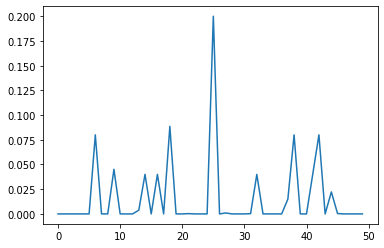

In [ ]:
plt.plot(weights)
plt.show

<function matplotlib.pyplot.show>

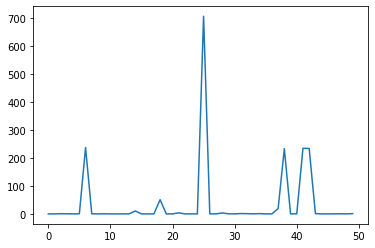

In [ ]:
plt.plot(times)
plt.show

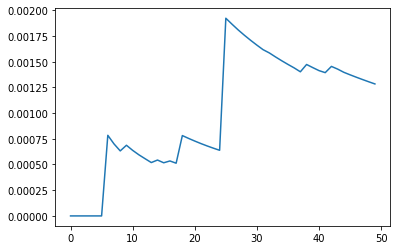

In [ ]:
d = []
for i in range(len(weights)):
    d.append(np.var(weights[:i+1]))

plt.plot(d)
plt.show()

In [ ]:
st_weight = sum(weights)/len(weights)
print("Средн: {}".format(st_weight))
st_time = sum(times)/len(times)
print("Среднее время: {}".format(st_time))
print("FOM: {}".format(1/(sum(d)/len(d))*st_time))

Средний вес: 0.01553151311077522
Среднее время: 34.941487020000004
FOM: 34889.59163094942
